# Import libraries

In [42]:
%matplotlib inline
import numpy as np
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import requests
import descartes
import calendar
import seaborn as sns
import matplotlib

# Import data

In [43]:
# Loading data (https://www.nti.org/analysis/articles/cns-north-korea-missile-test-database/). Encoding problem solved with 'unicode_escape'.
df = pd.read_csv('../data/north_korea_missile_test_database.csv', encoding= 'unicode_escape', index_col= "F1")
# Dropping unused columns.
df = df.drop(columns=['Launch Agency/Authority', 'Other Name', 'Additional Information', 'Source(s)', 'Launch Time (UTC)', 'Date Entered/Updated', 'Apogee'])

# Test DataFrame

In [89]:
df.head(1)

,Date,Missile Name,Missile Type,Facility Name,Facility Location,Facility Latitude,Facility Longitude,Landing Location,Distance Travelled,Confirmation Status,Test Outcome,Year,Month_Number,Month,# of Test,YYYYMM,Frequencies
F1,,,,,,,,,,,,,,,,,
1,1984-04-09,Scud-B,SRBM,Tonghae Satellite Launching Ground,"Hwadae County, North Hamgyong Province",40.849997,129.666664,Unknown,0.0,Confirmed,Success,1984,4,Apr,1,198404,17


# Cleaning data & formatting data

In [88]:
# Changing formats (str to int or float)
df['Distance Travelled'] = df['Distance Travelled'].apply(lambda x: x.replace('km', '') if isinstance(x, str) else x)
# And then, convert 'Unkown' values to numerics.
df['Distance Travelled'] = df['Distance Travelled'].replace('Unknown', 'NaN') 
# Finally, I can change it to numeric pandas table.
df['Distance Travelled'] = pd.to_numeric(df['Distance Travelled'], errors='coerce').fillna(0)
df['Landing Location'] = df['Landing Location'].apply(lambda x: x.replace('330km east of Hachinohe and 4000 km out into Pacific Ocean', '330km east of Hachinohe') if isinstance(x, str) else x)
# Changing 'location' data
df['Facility Latitude'] = pd.to_numeric(df['Facility Latitude'], errors='coerce')
df['Facility Longitude'] = pd.to_numeric(df['Facility Longitude'], errors='coerce')
# Date changes
df['Date'] = pd.to_datetime(df['Date'])
# Creating a new column for separating the year values in numeric format.
df['Year'] = df['Date'].dt.year
# Another column for changing number values to string values.
df['Month_Number'] = df['Date'].dt.month
# Another column for separating values to month specifically.
df['Month'] = df['Month_Number'].apply(lambda x: calendar.month_abbr[x])
# Another column for counting test numbers.
df["# of Test"] = 1
# Simplifying the Year/Month format.
df['YYYYMM'] = pd.to_datetime(df['Date'], format='%Y%m', errors='coerce')
df['YYYYMM'] = pd.to_datetime(df['Date']).dt.strftime('%Y%m')

# First plot: mapbox of the testing facility locations (Overview)

In [200]:
test_frequencies.sort_index().head(3)
sorted_df.head(3)

,Date,Missile Name,Missile Type,Facility Name,Facility Location,Facility Latitude,Facility Longitude,Landing Location,Distance Travelled,Confirmation Status,Test Outcome,Year,Month_Number,Month,# of Test,YYYYMM,Frequencies
F1,,,,,,,,,,,,,,,,,
121,2019-05-04,Hwasong-11A (KN-23),SRBM,Hodo Peninsula,"Kangwon Province, (North Korea)",39.40167,127.5369,NaN,0.0,Confirmed,Success,2019,5,May,1,201905,26
66,2015-04-02,KN-02,SRBM,Hodo Peninsula,"Kangwon Province, (North Korea)",39.40167,127.5369,Sea of Japan or East Sea,0.0,Confirmed,Success,2015,4,Apr,1,201504,26
35,2013-05-18,KN-02,SRBM,Hodo Peninsula,"Kangwon Province, (North Korea)",39.40167,127.5369,Sea of Japan or East Sea,0.0,Unconfirmed,Success,2013,5,May,1,201305,26


In [162]:
# Utilizing plotly.express, map out the locations with lat/lon data by test frequencies.
test_frequencies = df['Facility Name'].value_counts()
# Once counted values per item, give the match items the same outcomes for mapbox.
df['Frequencies'] = df['Facility Name'].map(test_frequencies)
# Reason for the sorted_df is to configure the legend items by the size.
sorted_df = df.sort_values(by='Frequencies', ascending=False)
# Create the scatter map plot
map_fig2 = px.scatter_mapbox(sorted_df, lat='Facility Latitude', lon='Facility Longitude',
                             color='Facility Name', size='Frequencies',
                             zoom=6, center={'lat': 39.17180415583127, 'lon': 126.551952046587},
                             width=1200, height=700, title='DPRK Missile Facility Locations')
# Configure the text and layout
map_fig2.update_layout(mapbox_style="carto-positron", title_font_size=25, title_font_family="Courier New")
map_fig2.update_layout(margin_autoexpand=True)
# Modify the legend position
map_fig2.update_layout(title=dict(x=0.5, xanchor='center'))
map_fig2.update_layout(margin=dict(t=45, l=0, r=0, b=5))
# Display the scatter map plot
map_fig2.show()

# Second plot: Number of missile tests by timeline

In [134]:
merged_df.drop(columns=['Frequencies', 'Month_Number']).head(3)

,Year,Facility Latitude,Facility Longitude,Distance Travelled,# of Test
0,1984,245.099980,777.999984,0.0,6.0
1,1985,NaN,NaN,NaN,0.0
2,1986,40.849997,129.666664,0.0,1.0


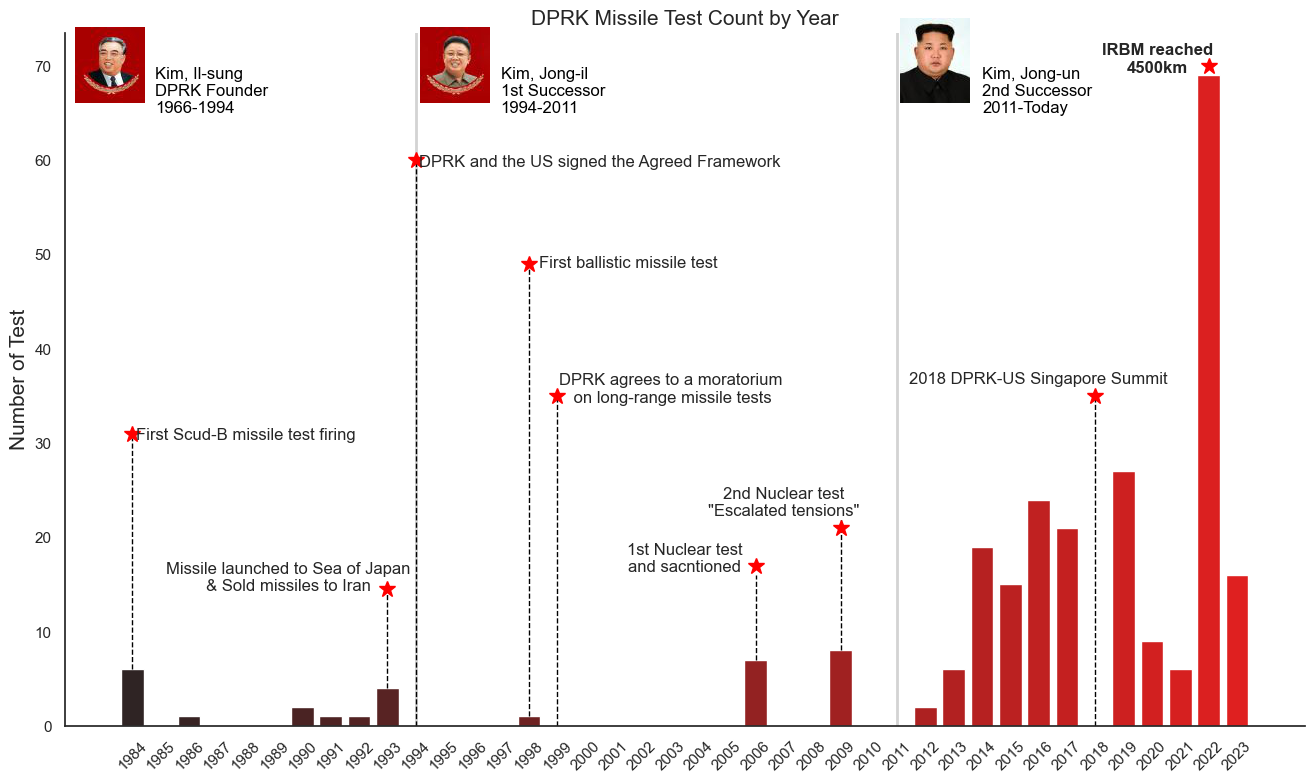

In [202]:
# Making a chart that counts the total missile test by year
grouped_total_num = df.groupby('Year').sum(numeric_only=True).reset_index()
# Create a range of years from the minimum to maximum years in the data
year_chart = range(df['Year'].min(), df['Year'].max() + 1)
# Create a DataFrame with listing all years
year_chart_df = pd.DataFrame({'Year': year_chart})
# Merge the year_chart_df with the grouped DataFrame to fill missing years with 0 test counts
merged_df = pd.merge(year_chart_df, grouped_total_num, how='left', on='Year')
merged_df['# of Test'] = merged_df['# of Test'].fillna(0)
# Frequencie and Month_Number are not neccessary for this chart. Therefore, dropped those
#merged_df.drop(columns=['Frequencies', 'Month_Number'])
# Create a gradient color palette using seaborn's light_palette()
n_colors = len(merged_df)  
# Number of colors in the palette (one for each year)
gradient_palette = sns.dark_palette("red", n_colors=n_colors)
# Create the bar chart with the gradient color palette
plt.figure(figsize=(16, 9))
sns.barplot(x='Year', y='# of Test', data=merged_df, palette=gradient_palette)
# Customize the plot
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
# Set x-axis label and title
plt.xlabel(xlabel=None, fontsize=15)
plt.ylabel('Number of Test', fontsize=15)
plt.title('DPRK Missile Test Count by Year', fontsize=15)
plt.xticks(rotation=45)


# Below lines are not essential elements for this chart. But these helps visualization.
# The graph functions well When copy and paste above lines in a new jupyter notebook.

# Give the vertical lines to seprate regimes 
plt.axvline(10, 0, 15, color='lightgray', linestyle='-', linewidth='2')
plt.axvline(27, 0, 15, color='lightgray', linestyle='-', linewidth='2')
# Kim Il-sung
image1 = plt.imread('../img/kis.jpg')
image_position1 = (75, 680) 
plt.figimage(image1, image_position1[0], image_position1[1], alpha=1, zorder=10)
# Kim Jung-il
image2 = plt.imread('../img/kji.jpg')
image_position2 = (420, 680) 
plt.figimage(image2, image_position2[0], image_position2[1], alpha=1, zorder=10)
# Kim Jong-un
image3 = plt.imread('../img/kju.jpg')
image_position3 = (900, 680) 
plt.figimage(image3, image_position3[0], image_position3[1], alpha=1, zorder=10)
# Add comments next to each pictures
plt.text(0.8, 65,'Kim, Il-sung\nDPRK Founder\n1966-1994', fontsize=12, color='black')
plt.text(13, 65, 'Kim, Jong-il\n1st Successor\n1994-2011', fontsize=12, color='black')
plt.text(30, 65, 'Kim, Jong-un\n2nd Successor\n2011-Today', fontsize=12, color='black')
# First comment & line descriptions
x1 = 0
y1 = merged_df.loc[0, '# of Test']
comment1 = 'First Scud-B missile test firing'
line_length1 = 24.5  # Extend the line by 5 points
plt.text(x1 + 4, y1 + 24, comment1, ha='center', va='bottom')
plt.plot([x1, x1], [y1, y1 + line_length1], color='black', linewidth=1, linestyle='--')
# First star
star_x1 = x1
star_y1 = y1 + 25  # Adjust the vertical position of the star
plt.plot(star_x1, star_y1, marker='*', color='red', markersize=12)
# Second comment & line descriptions
x2 = 9
y2 = merged_df.loc[9, '# of Test']
comment2 = 'Missile launched to Sea of Japan\n& Sold missiles to Iran'
line_length2 = 10
plt.text(x2 - 3.5, y2 + 10, comment2, ha='center', va='bottom')
plt.plot([x2, x2], [y2, y2 + line_length2], color='black', linewidth=1, linestyle='--')
line_length2 = 24.5  # Extend the line by 5 points
# Second star
star_x2 = x2
star_y2 = y2 + 10.5  # Adjust the vertical position of the star
plt.plot(star_x2, star_y2, marker='*', color='red', markersize=12)
# Third comment & line descriptions
x3 = 10
y3 = merged_df.loc[10, '# of Test']
comment3 = 'DPRK and the US signed the Agreed Framework'
line_length3 = 60
plt.text(x3 + 6.5, y3 + 59, comment3, ha='center', va='bottom')
plt.plot([x3, x3], [y3, y3 + line_length3], color='black', linewidth=1, linestyle='--')
# Third star
star_x3 = x3
star_y3 = y3 + 60  # Adjust the vertical position of the star
plt.plot(star_x3, star_y3, marker='*', color='red', markersize=12)
# Forth comment & line descriptions
x4 = 14
y4 = merged_df.loc[14, '# of Test']
comment4 = 'First ballistic missile test'
line_length4 = 48
plt.text(x4 + 3.5, y4 + 47.3, comment4, ha='center', va='bottom')
plt.plot([x4, x4], [y4, y4 + line_length4], color='black', linewidth=1, linestyle='--')
line_length4 = 48.5  # Extend the line by 5 points
# Fourth star
star_x4 = x4
star_y4 = y4 + 48  # Adjust the vertical position of the star
plt.plot(star_x4, star_y4, marker='*', color='red', markersize=12)
# Fifth comment & line descriptions
x5 = 15
y5 = merged_df.loc[15, '# of Test']
comment5 = 'DPRK agrees to a moratorium\n on long-range missile tests'
line_length5 = 35
plt.text(x5 + 4, y5 + 34, comment5, ha='center', va='bottom')
plt.plot([x5, x5], [y5, y5 + line_length5], color='black', linewidth=1, linestyle='--')
# Fifth star
star_x5 = x5
star_y5 = y5 + 35  # Adjust the vertical position of the star
plt.plot(star_x5, star_y5, marker='*', color='red', markersize=12)
# Sixth comment & line descriptions
x6 = 34
y6 = merged_df.loc[34, '# of Test']
comment6 = '2018 DPRK-US Singapore Summit'
line_length6 = 35
plt.text(x6 - 2, y6 + 36, comment6, ha='center', va='bottom')
plt.plot([x6, x6], [y6, y6 + line_length6], color='black', linewidth=1, linestyle='--')
# Sixth star
star_x6 = x6
star_y6 = y6 + 35  # Adjust the vertical position of the star
plt.plot(star_x6, star_y6, marker='*', color='red', markersize=12)
# Seventh comment & line descriptions
x7 = 38
y7 = merged_df.loc[38, '# of Test']
comment7 = 'IRBM reached\n4500km'
line_length7 = 30
plt.text(x7 - 1.8, y7 + 0, comment7, ha='center', va='bottom', weight ='bold')
# Seventh star
star_x7 = x7
star_y7 = y7 + 1  # Adjust the vertical position of the star
plt.plot(star_x7, star_y7, marker='*', color='red', markersize=12)
# Eight comment & line descriptions
x8 = 22
y8 = merged_df.loc[22, '# of Test']
comment8 = '1st Nuclear test\nand sacntioned'
line_length8 = 9
plt.text(x8 - 2.5, y8 + 9, comment8, ha='center', va='bottom')
plt.plot([x8, x8], [y8, y8 + line_length8], color='black', linewidth=1, linestyle='--')
# Eight star
star_x8 = x8
star_y8 = y8 + 10  # Adjust the vertical position of the star
plt.plot(star_x8, star_y8, marker='*', color='red', markersize=12)
# Nineth comment & line descriptions
x9 = 25
y9 = merged_df.loc[25, '# of Test']
comment9 = '2nd Nuclear test\n"Escalated tensions"'
line_length9 = 14
plt.text(x9 - 2, y9 + 14, comment9, ha='center', va='bottom')
plt.plot([x9, x9], [y9, y9 + line_length9], color='black', linewidth=1, linestyle='--')
# Nineth star
star_x9 = x9
star_y9 = y9 + 13  # Adjust the vertical position of the star
plt.plot(star_x9, star_y9, marker='*', color='red', markersize=12)
# Display the bar chart
plt.show()

# Third plot: Number of successes and failures by facility names

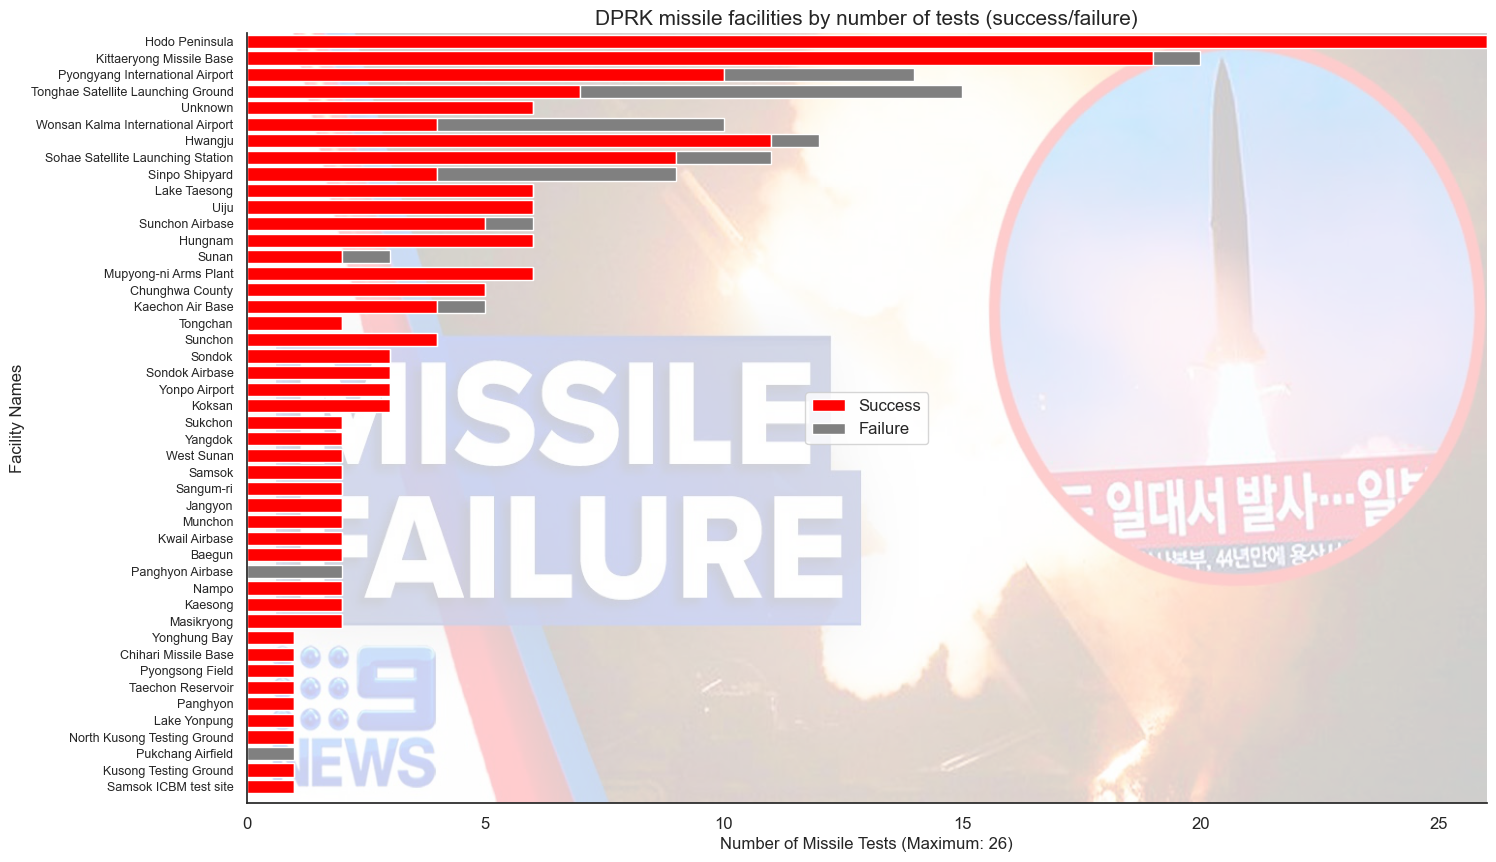

In [111]:
# Counting of total number
test_frequencies = df['Facility Name'].value_counts()
facility_names_reversed = test_frequencies.index[::-1]
facility_counts_reversed = test_frequencies.values[::-1]
# Counting Success and Failure numbers by facility name
facility_success = df.groupby('Facility Name')['Test Outcome'].apply(lambda x: (x == 'Success').sum())
facility_failure = df.groupby('Facility Name')['Test Outcome'].apply(lambda x: (x == 'Failure').sum())
success_counts = facility_success.reindex(facility_names_reversed).values
failure_counts = facility_failure.reindex(facility_names_reversed).values
# Determine the figure size
plt.figure(figsize=(16, 10))
# Configuring the bar colors
success_color = 'red' 
failure_color = 'gray' 
# Starting to define what goes into the chart
bar_positions = np.arange(len(facility_names_reversed))
# Setting the bar
plt.barh(bar_positions, success_counts, color=success_color)
plt.barh(bar_positions, failure_counts, left=success_counts, color=failure_color)
# Additional visualization
plt.yticks(bar_positions, facility_names_reversed)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=9)
plt.xlabel('Number of Missile Tests (Maximum: 26)', size=12)
plt.ylabel('Facility Names', size=12)
plt.title('DPRK missile facilities by number of tests (success/failure)', size=15)
plt.xticks(rotation=0)
# Set the legend
legend_font_size = 12
plt.legend(['Success', 'Failure'], loc='center', prop={'size': legend_font_size})
# Additional chart configuration - Not neccessary
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
# Removed white space before and after bars
plt.ylim(bar_positions[0]-1, bar_positions[-1]+0.5)
# Added a watermark background
watermark = plt.imread('../img/missile_failure_background.jpeg') 
x_limits = plt.xlim()
y_limits = plt.ylim()
extent = [*x_limits, *y_limits]
plt.imshow(watermark, extent=extent, aspect='auto', alpha=0.2)
plt.show()

# Fourth plot: Average and maximum distance travelled by year

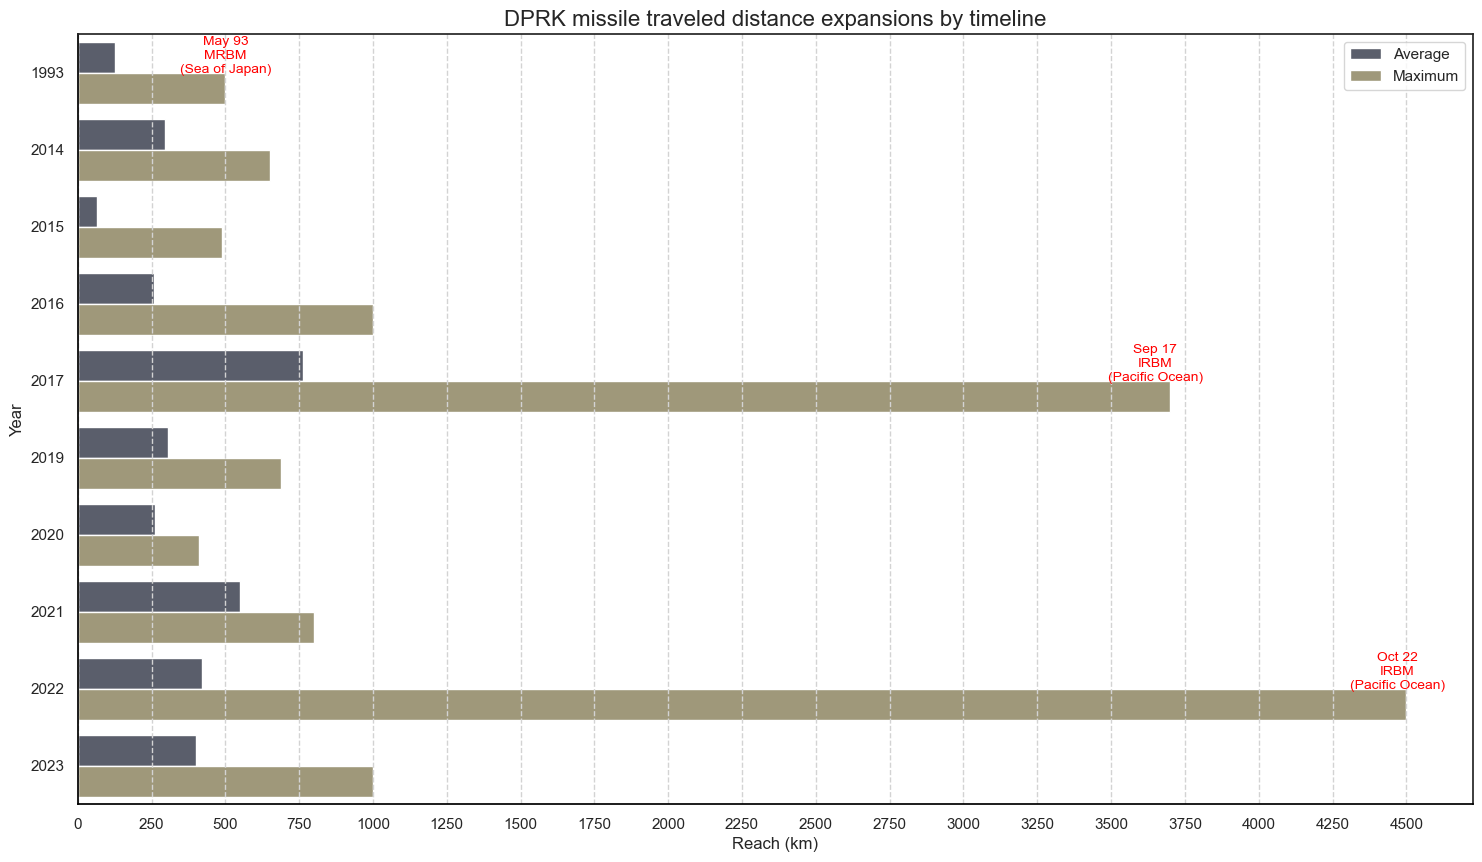

In [157]:
# This chart requires two different values (max & mean). Therefore, the following lines defines both max range and mean range
df_distance = df[['Year','Distance Travelled']]
grouped_distance = df_distance.groupby('Year')
df_range_max = grouped_distance.max().reset_index()
df_range_max = df_range_max.dropna()
df_range_max.rename(columns = {"Distance Travelled": "Reach (km)"}, inplace=True)
df_range_max['Category'] = "Maximum"
# Here starts the mean range
df_distance = df[['Year','Distance Travelled']]
grouped_distance = df_distance.groupby('Year')
df_range_mean = grouped_distance.mean().reset_index()
df_range_mean = df_range_mean.dropna()
df_range_mean.rename(columns = {"Distance Travelled": "Reach (km)"}, inplace=True)
df_range_mean['Category'] = "Average"
# Now, concatenate two data (max & mean) to blend two data in a same bar
df_reach = pd.concat([df_range_mean,df_range_max])
df_reach = df_reach[df_reach['Reach (km)'] != 0.0]
# Configuration
fig = plt.figure(figsize=(18, 10))
ax1 = sns.set_theme(style="white")
ax1 = plt.gca().spines['left'].set_color('black')
ax1 = plt.gca().spines['bottom'].set_color('black')
plt.title('DPRK missile traveled distance expansions by timeline', fontsize = 16, loc='center')
# Creating a plot
ax1 = sns.barplot(x='Reach (km)', y='Year', hue="Category", data=df_reach, orient="h", palette="cividis")
# Setting the tick marks
xticks = np.arange(0, df_reach['Reach (km)'].max()+250, 250)
plt.xticks(xticks, xticks.astype(int))
# xticks lines
for xtick in xticks:
    plt.axvline(xtick, -1, 5, color='lightgray', linestyle='--', linewidth='1')
# Adding comments 
ax1 = plt.text(500, 0, 'May 93\nMRBM\n(Sea of Japan)', fontsize=10, color='red', horizontalalignment='center')
ax1 = plt.text(3650, 4, 'Sep 17\nIRBM\n(Pacific Ocean)', fontsize=10, color='red', horizontalalignment='center')
ax1 = plt.text(4470, 8, 'Oct 22\nIRBM\n(Pacific Ocean)', fontsize=10, color='red', horizontalalignment='center')
ax1 = plt.legend(loc='upper right')

plt.show()

# Fifth plot: Number of missile test by missile type

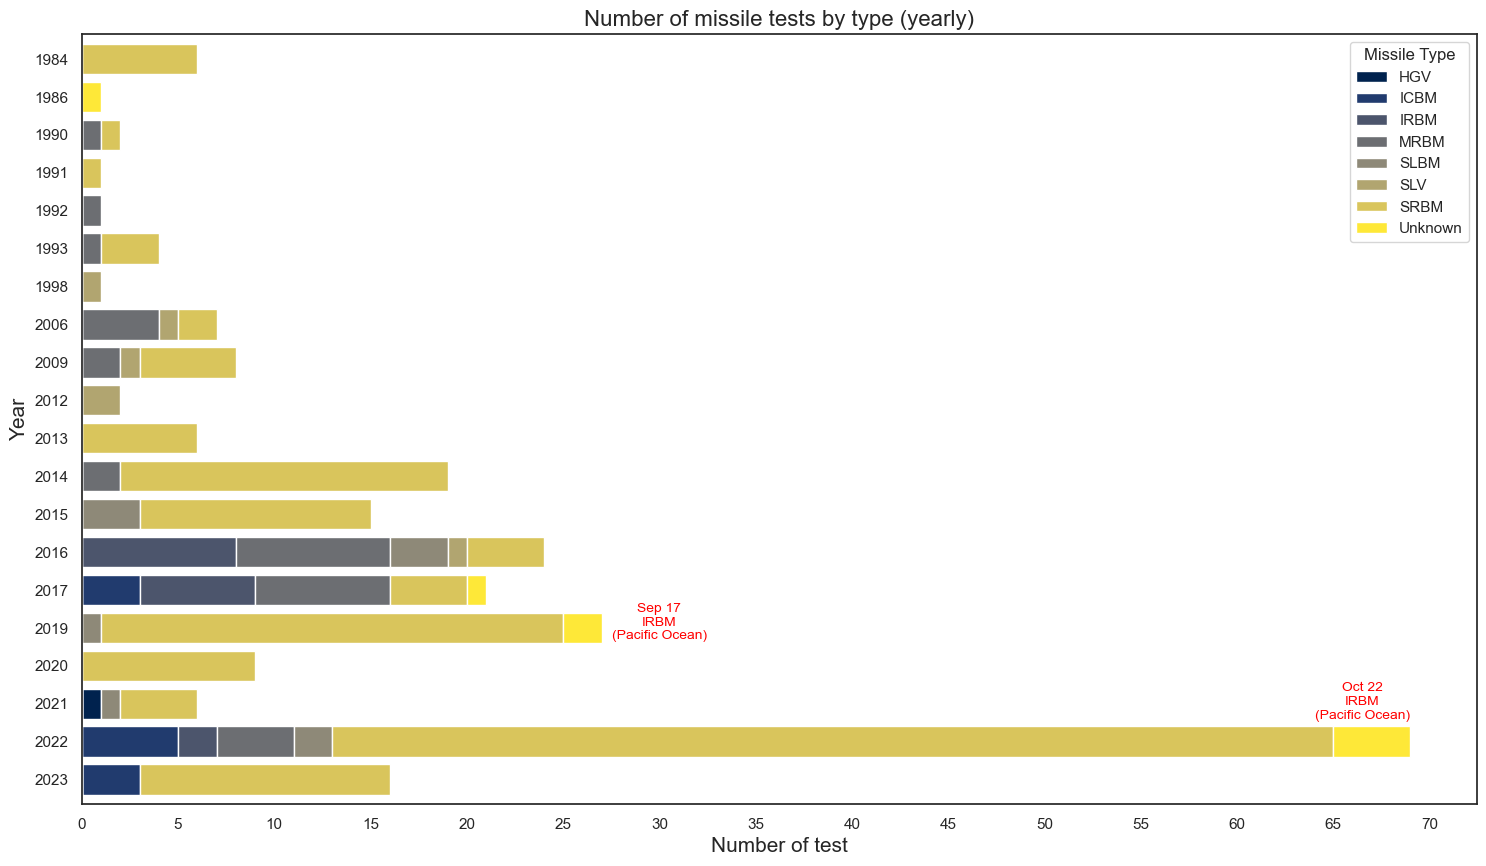

In [156]:
# This color is color-blind friendly
colors = plt.cm.GnBu(np.linspace(0, 1, 10))

# Stacked graph for number of test by year
fig, ax = plt.subplots(figsize=(18, 10))
# Creating a pivot table with three columns. Sum the # of tests
pivot_table = df.pivot_table(index='Year', columns='Missile Type', values='# of Test', aggfunc='sum')
# To order it properly, setting the index backwards
pivot_table = pivot_table.iloc[::-1] 
# Configure the plot
pivot_table.plot(kind='barh', stacked=True, ax=ax,width=0.8, cmap='cividis')
plt.xlabel('Number of test', size='15')
plt.ylabel('Year', size='15')
plt.title('Number of missile tests by type (yearly)', size='16')
plt.legend(title='Missile Type', bbox_to_anchor=(1, 1))
# Setting the xtick incremending by 5
plt.xticks(range(0, 71, 5))
# Adding comments
plt.text(30, 3.7, 'Sep 17\nIRBM\n(Pacific Ocean)', fontsize=10, color='red', horizontalalignment='center')
plt.text(66.5, 1.6, 'Oct 22\nIRBM\n(Pacific Ocean)', fontsize=10, color='red', horizontalalignment='center')

plt.show()

In [144]:
df_locations

,Location,Coordinates,Count,Latitude,Longitude
0,Sea of Japan or East Sea,"(39.955235648894956, 134.61977359260942)",196,39.955236,134.619774
1,Yellow Sea or West Sea,"(37.59154703499678, 124.86670024925259)",10,37.591547,124.866700
2,Pacific Ocean,"(32.03899252565651, 175.45833648092025)",5,32.038993,175.458336
3,330km east of Hachinohe,"(41.27280362125239, 148.20008702447393)",1,41.272804,148.200087
4,Unknown,"(0, 0)",19,0.000000,0.000000


# Sixth plot: missile landing locations

In [199]:
# Almost similar to the facility map graph, need to count by 'Landing Location'
landing_location_counts = df['Landing Location'].value_counts().reset_index()
# Gives the column values
landing_location_counts.columns = ['Location', 'Count']
# From Google map, searched estimated location data
landing_locations = {
    'Sea of Japan or East Sea': (39.955235648894956, 134.61977359260942),
    'Yellow Sea or West Sea': (37.59154703499678, 124.86670024925259),
    'Pacific Ocean': (32.03899252565651, 175.45833648092025), 
    '330km east of Hachinohe': (41.27280362125239, 148.20008702447393),
    'Unknown' : (0,0)
}
# Based on 'landing location' data, creating a new dataframe
df_locations = pd.DataFrame(landing_locations.items(), columns=['Location', 'Coordinates'])
df_locations = pd.merge(df_locations, landing_location_counts, on='Location', how='left')
# Adding 'Latitude', 'Longitude' columns in df_locations
df_locations[['Latitude', 'Longitude']] = pd.DataFrame(df_locations['Coordinates'].tolist(), index=df_locations.index)
# Map out the df_locations
map_fig2 = px.scatter_mapbox(df_locations, lat='Latitude', lon='Longitude', hover_name='Location',
                             color='Location', size='Count', size_max=30,  
                             zoom=2.3, center={'lat': 36.99233273149936, 'lon': -175.65753675093146},
                             width=1200, height=700, title='DPRK Missile Landing Locations')
# Additional layout changes - Not neccessary
map_fig2.update_layout(title=dict(x=0.5, xanchor='center'))
map_fig2.update_layout(mapbox_style="carto-darkmatter", title_font_size=25, title_font_family="Courier New")
map_fig2.update_layout(margin=dict(t=45, l=5, r=0, b=5))

map_fig2.show()